In [1]:
import logging
logging.captureWarnings(True)

# Tutorial: Quickstart

Here we will demonstrate a simple example of training a convolutional conditional neural process (ConvCNP) to spatially interpolate ERA5 data.

We can go from imports to predictions with a trained model in less than 30 lines of code!

In [2]:
import deepsensor.torch
from deepsensor.data import DataProcessor, TaskLoader
from deepsensor.model import ConvNP
from deepsensor.train import Trainer

import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook

In [3]:
# Load raw data
ds_raw = xr.tutorial.open_dataset("air_temperature")["air"] - 273.15

In [4]:
# Normalise data
data_processor = DataProcessor(x1_name="lat", x2_name="lon")
ds = data_processor(ds_raw)

In [5]:
# Set up task loader
task_loader = TaskLoader(context=ds, target=ds)

In [6]:
# Set up model
model = ConvNP(data_processor, task_loader)

dim_yc inferred from TaskLoader: (1,)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
points_per_unit inferred from TaskLoader: 52
encoder_scales inferred from TaskLoader: [0.009615384042263031]
decoder_scale inferred from TaskLoader: 0.019230769230769232


In [7]:
# Generate training tasks with up to 10% of grid cells passed as context and all grid cells
# passed as targets
train_tasks = []
for date in pd.date_range("2013-01-01", "2014-11-30")[::7]:
    task = task_loader(date, context_sampling=np.random.uniform(0.0, 0.1), target_sampling="all")
    train_tasks.append(task)

In [8]:
# Train model
trainer = Trainer(model, lr=5e-5)
losses = []
for epoch in tqdm_notebook(range(20)):
    batch_losses = trainer(train_tasks)
    losses.append(np.mean(batch_losses))

  0%|          | 0/15 [00:00<?, ?it/s]

Text(0, 0.5, 'Loss')

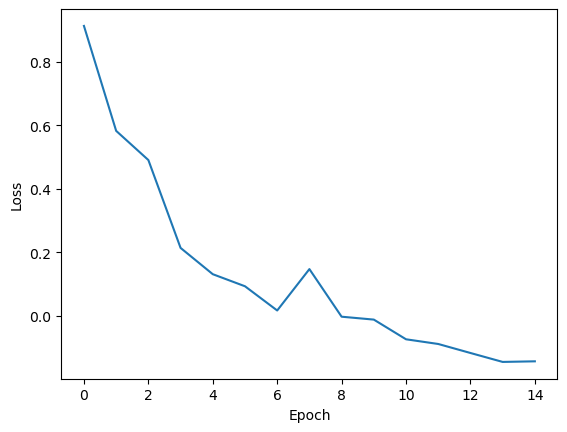

In [9]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [10]:
# Predict on new task with 30 context points and a dense grid of target points
date = "2014-12-31"
test_task = task_loader(date, 30)
pred = model.predict(test_task, X_t=ds_raw)

After training, the model can predict directly to `xarray` in your data's original units and coordinate system:

In [11]:
pred["air"]

<xarray.Dataset>
Dimensions:  (time: 1, lat: 25, lon: 53)
Coordinates:
  * time     (time) datetime64[ns] 2014-12-31
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
Data variables:
    mean     (time, lat, lon) float32 -19.37 -19.85 -20.22 ... 23.12 23.15 23.14
    std      (time, lat, lon) float32 12.36 12.15 11.92 ... 2.209 2.293 2.379

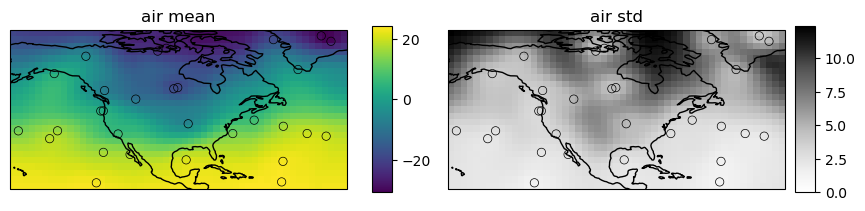

In [12]:
import cartopy.crs as ccrs
fig = deepsensor.plot.prediction(pred, date, data_processor, task_loader, test_task, crs=ccrs.PlateCarree())

We can also predict directly to `pandas` containing a timeseries of predictions at off-grid locations
by passing a `numpy` array of target locations to the `X_t` argument of `.predict`:

In [13]:
# Predict at two off-grid locations over December 2014 with 30 random, fixed context points
test_tasks = task_loader(pd.date_range("2014-12-01", "2014-12-31"), 30, seed_override=42)
pred = model.predict(test_tasks, X_t=np.array([[50, 280], [40, 250]]).T)

In [14]:
pred["air"]

mean       std
time       lat lon                     
2014-12-01 50  280  -4.053979  6.507388
           40  250   -2.28431  6.230555
2014-12-02 50  280  -9.130598  7.660693
           40  250   0.387284  4.393764
2014-12-03 50  280 -10.997772  7.900775
...                       ...       ...
2014-12-29 40  250  -1.315994  5.181729
2014-12-30 50  280 -13.502054  8.421058
           40  250  -8.831409  6.143065
2014-12-31 50  280 -15.734423  8.531667
           40  250 -14.386276  6.166073

[62 rows x 2 columns]

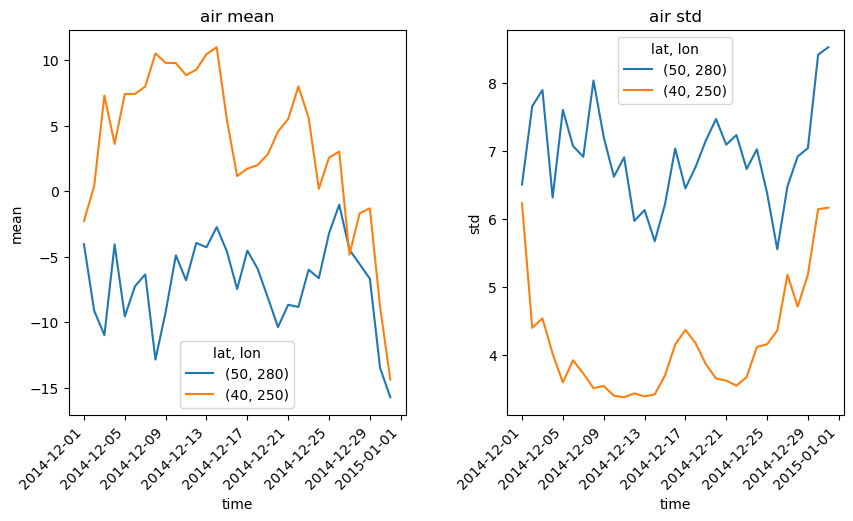

In [15]:
fig = deepsensor.plot.prediction(pred)